In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np

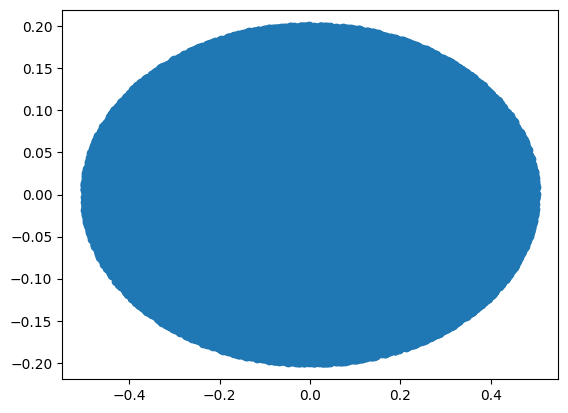

In [2]:
def generate_ellipse(n = 10000, scale=(0.5,0.2)):
    data = (torch.rand((n,2))-0.5)*2
    dist = torch.sum(torch.square(data),axis=1)
    data = data[torch.where(dist <= 1)]
    data *= torch.tensor(scale)
    return data

train_loader = generate_ellipse(100000)
test_loader = generate_ellipse(10000)
plt.scatter(np.array(train_loader)[:,0], np.array(train_loader)[:,1])

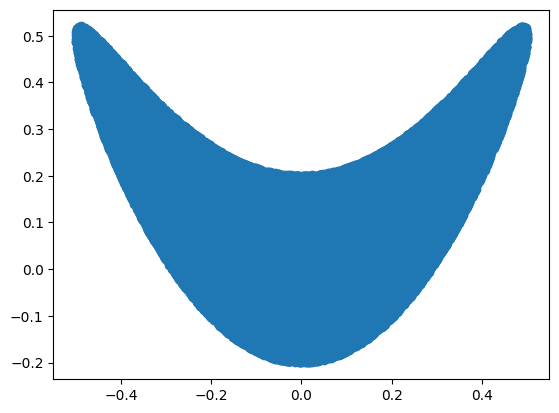

In [16]:
def generate_banana(n=100000):
    train_loader = generate_ellipse(n)
    train_loader[:, 1] = train_loader[:,1] + 2*train_loader[:,0]**2
    return train_loader
train_loader = generate_banana()
plt.scatter(np.array(train_loader)[:,0], np.array(train_loader)[:,1])

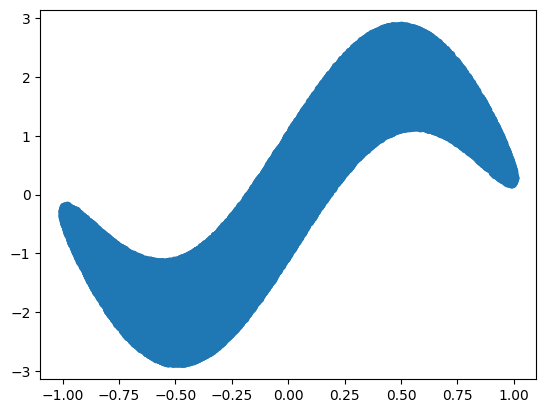

In [22]:
def generate_wave(n=100000):
    train_loader = generate_ellipse(n, (1,1))
    train_loader[:, 1] = train_loader[:,1] + 2*torch.sin(3*train_loader[:,0])
    return train_loader
train_loader = generate_wave()
plt.scatter(np.array(train_loader)[:,0], np.array(train_loader)[:,1])

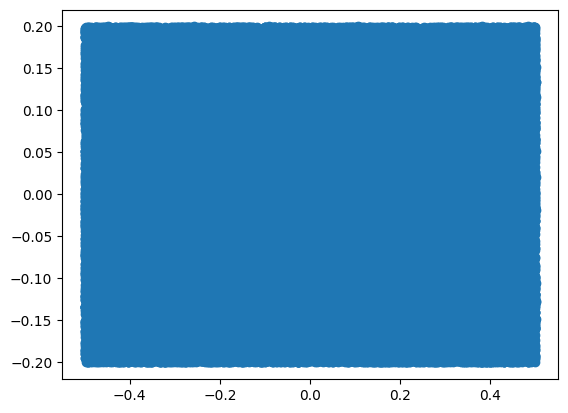

In [25]:
def generate_square(n=100000, scale=(0.5,0.2)):
    data = (torch.rand((n,2))-0.5)*2
    data *= torch.tensor(scale)
    return data
train_loader = generate_square()
plt.scatter(np.array(train_loader)[:,0], np.array(train_loader)[:,1])

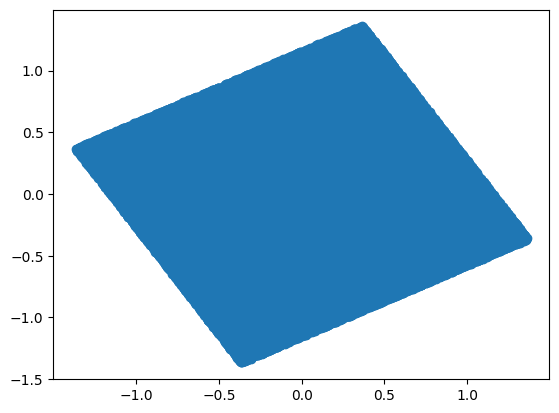

In [44]:
def generate_diamond(n=100000, angle=torch.pi/6):
    train_loader = generate_square(n, (1,1))
    angle = torch.tensor(angle)
    s = torch.sin(angle)
    c = torch.cos(angle)
    rot = torch.stack([torch.stack([c, -s]),
                       torch.stack([s, c])])
    train_loader = (rot @ train_loader.T).T
    return train_loader
train_loader = generate_diamond()
plt.scatter(np.array(train_loader)[:,0], np.array(train_loader)[:,1])

In [28]:
import torch
from torch import nn
from model import LUNet
from matplotlib import pyplot as plt
import numpy as np

from torch.optim.lr_scheduler import StepLR
from train import training_routine_gaussian, training_routine_uniform, training_routine_uniform_method2
from test import testing_routine
from functions import uniform_circle_log_likelihood, uniform_circle_log_likelihood_method2, gaussian_loss_function

from pathlib import Path

from visuals import plot_transformed_grid_and_density, compute_uniform_circle_density, compute_gaussian_density

In [7]:
torch.set_default_dtype(torch.float64)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [8]:
model = LUNet(num_lu_blocks=12, layer_size = 2).to(device)

In [9]:
model

LUNet(
  (nonlinearity): LeakySoftplus()
  (intermediate_lu_blocks): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=False)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=2, bias=False)
    (3): Linear(in_features=2, out_features=2, bias=True)
    (4): Linear(in_features=2, out_features=2, bias=False)
    (5): Linear(in_features=2, out_features=2, bias=True)
    (6): Linear(in_features=2, out_features=2, bias=False)
    (7): Linear(in_features=2, out_features=2, bias=True)
    (8): Linear(in_features=2, out_features=2, bias=False)
    (9): Linear(in_features=2, out_features=2, bias=True)
    (10): Linear(in_features=2, out_features=2, bias=False)
    (11): Linear(in_features=2, out_features=2, bias=True)
    (12): Linear(in_features=2, out_features=2, bias=False)
    (13): Linear(in_features=2, out_features=2, bias=True)
    (14): Linear(in_features=2, out_features=2, bias=False)
    (15): Linear(in_features=2, out_

In [18]:
weights = []
for i, layer in enumerate(model.intermediate_lu_blocks):
    weights.append(layer.weight.grad)
    if i % 2 == 1:
        weights.append(layer.bias.grad)

for i, layer in enumerate(model.final_lu_block):
    weights.append(layer.weight.grad)
    if i % 2 == 1:
        weights.append(layer.bias.grad) 

shapes = []
for i, layer in enumerate(model.intermediate_lu_blocks):
    shapes.append(layer.weight.shape)
    if i % 2 == 1:
        shapes.append(layer.bias.shape)

for i, layer in enumerate(model.final_lu_block):
    shapes.append(layer.weight.shape)
    if i % 2 == 1:
        shapes.append(layer.bias.shape) 

shapes

[torch.Size([2, 2]),
 torch.Size([2, 2]),
 torch.Size([2]),
 torch.Size([2, 2]),
 torch.Size([2, 2]),
 torch.Size([2]),
 torch.Size([2, 2]),
 torch.Size([2, 2]),
 torch.Size([2]),
 torch.Size([2, 2]),
 torch.Size([2, 2]),
 torch.Size([2]),
 torch.Size([2, 2]),
 torch.Size([2, 2]),
 torch.Size([2]),
 torch.Size([2, 2]),
 torch.Size([2, 2]),
 torch.Size([2]),
 torch.Size([2, 2]),
 torch.Size([2, 2]),
 torch.Size([2]),
 torch.Size([2, 2]),
 torch.Size([2, 2]),
 torch.Size([2]),
 torch.Size([2, 2]),
 torch.Size([2, 2]),
 torch.Size([2]),
 torch.Size([2, 2]),
 torch.Size([2, 2]),
 torch.Size([2]),
 torch.Size([2, 2]),
 torch.Size([2, 2]),
 torch.Size([2]),
 torch.Size([2, 2]),
 torch.Size([2, 2]),
 torch.Size([2]),
 torch.Size([2, 2]),
 torch.Size([2, 2]),
 torch.Size([2])]

In [19]:
# Isoperimetrisches Problem

def isoperimetric_loss(points):
    diff = torch.diff(torch.concatenate((points, points[:1])), axis=0)
    distances = torch.sum(diff**2, axis=1)**0.5
    return torch.sum(distances)

def orthogonal_projection(v, grad):
    return grad - grad@v * v / torch.norm(v)**2


In [106]:
orthogonal_projection( torch.tensor([1,0,0.]),torch.tensor([1,2,3.]))
circle = torch.tensor(circle)
isoperimetric_loss(circle)

tensor(6.2832)

In [20]:
def get_grad_vector(model):
    weights = []
    
    for i, layer in enumerate(model.intermediate_lu_blocks):
        weights.append(layer.weight.grad)
        if i % 2 == 1:
            weights.append(layer.bias.grad)
    
    for i, layer in enumerate(model.final_lu_block):
        weights.append(layer.weight.grad)
        if i % 2 == 1:
            weights.append(layer.bias.grad) 

    vector = torch.concatenate([w.flatten() for w in weights])
    return vector

def get_shapes(model):

    shapes = []
    for i, layer in enumerate(model.intermediate_lu_blocks):
        shapes.append(layer.weight.shape)
        if i % 2 == 1:
            shapes.append(layer.bias.shape)
    
    for i, layer in enumerate(model.final_lu_block):
        shapes.append(layer.weight.shape)
        if i % 2 == 1:
            shapes.append(layer.bias.shape) 

    return shapes 

def get_weights_from_vector(vector, shapes):
    lengths = [np.prod(s) for s in shapes]
    return [t.reshape(shapes[i]) for i,t in  enumerate(torch.split(vector, lengths))]

def assign_grad_weights(model, grad_weights):
    counter = 0
            
    for i, layer in enumerate(model.intermediate_lu_blocks):
        layer.weight.grad = grad_weights[counter]
        counter += 1
        if i % 2 == 1:
            layer.bias.grad = grad_weights[counter]
            counter += 1
            
    for i, layer in enumerate(model.final_lu_block):
        layer.weight.grad = grad_weights[counter]
        counter += 1
        if i % 2 == 1:
            layer.bias.grad = grad_weights[counter]
            counter += 1



In [107]:
def compute_area_triangle(points):
    diff = torch.diff(torch.concatenate((points, points[:1])), axis=0)
    distances = torch.sum(diff**2, axis=1)**0.5
    s = torch.sum(distances) / 2
    return (s*torch.prod(s - distances))**0.5
    
points = torch.tensor([[1,2], [3,4], [5,100]])
print(compute_area_triangle(points))

def compute_volume(points, origin=torch.tensor([0,0], device=device, requires_grad=False)):
    sum_vol = 0
    for i in range(points.shape[0]-1):
        #print(compute_area_triangle(torch.concatenate([origin, points[i], points[i+1]]).reshape(3,2)))
        sum_vol += compute_area_triangle(torch.concatenate([origin, points[i], points[i+1]]).reshape(3,2))
    sum_vol +=compute_area_triangle(torch.concatenate([origin, points[-1], points[0]]).reshape(3,2))
    return sum_vol


def compute_area(points, origin=torch.tensor([0.,0.], device=device, requires_grad=False)):
    repeated = origin.repeat(points.shape[0], 1)
    stacked_points = torch.stack((repeated, points, torch.roll(points, -1, 0), repeated))
    t=torch.diff(stacked_points, axis=0)
    length=torch.sum(t**2, axis=2)**0.5
    s = torch.sum(length, axis=0)/2
    area_triangles=torch.prod(s-length,axis=0)**0.5 *s**0.5#, s, length, s-length
    area=torch.sum(area_triangles)
    return area


def compute_area2(points, origin=torch.tensor([0.,0.], device=device, requires_grad=False)):
    coordinates = points - origin
    
    #return torch.sum(torch.sum(coordinates**2, axis=1)**0.5)
    return torch.sum(coordinates)

tensor(94.0000)


tensor(3.1416)

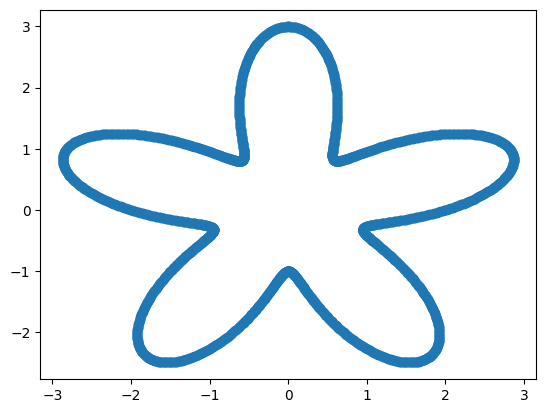

In [108]:
angles = np.linspace(0, 2*np.pi, 2000)
circle = np.stack((np.cos(angles), np.sin(angles)), axis=1)
amplitude = np.sin(5*angles)+2
star = circle*amplitude.reshape(-1,1)

plt.plot(star[:,0], star[:,1], '-o')
# for circle in np.split(grid_points, 10):
#     plt.plot(3*circle[:,0], 3*circle[:,1], '-o')
star = torch.tensor(star, device=device, requires_grad=False)
star = torch.concatenate((torch.tensor([[0.,0.]], device=device, requires_grad = False), star))
compute_volume(torch.tensor(circle),origin=torch.tensor([0,0], device='cpu', requires_grad=False))

In [228]:
def training_routine_isoperimetric(model, train_data, optimizer):
    torch.autograd.set_detect_anomaly(False)
    model.train()
    #train_loss = 0

    # # get volume grad
    # optimizer.zero_grad(set_to_none=True)
    # output = model(train_data)
    # origin = output[:1]
    # volume = compute_area2(output[1:], origin)
    # volume.backward()
    # #nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.001, norm_type=1)
    # volume_grad = get_grad_vector(model)
    # #print(volume, volume_grad[:10])
    # print('volume', volume)
    
    # get loss grad
    optimizer.zero_grad(set_to_none=True)
    output = model(train_data[1:])
    loss = isoperimetric_loss(output)
    loss.backward()
    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.001, norm_type=1)
    
    # # project on subspace
    # grad = get_grad_vector(model)
    # #print(grad[:10])
    # grad_projected = orthogonal_projection(volume_grad, grad)
    # #print(grad_projected[:10])
    # shapes = get_shapes(model)
    # grad_weigths = get_weights_from_vector(grad_projected, shapes)
    
    # # assign values
    # assign_grad_weights(model, grad_weigths)
    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1, norm_type=1)
    
    # train step
    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1, norm_type=1)
    optimizer.step()
    loss = loss.detach()
    print('loss', loss)
    #return volume_grad, grad 

In [229]:
model = LUNet(num_lu_blocks=3, layer_size = 2).to(device)

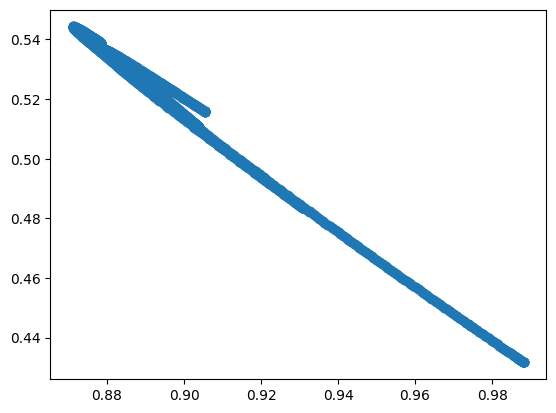

In [230]:
transformed = model(star)
transformed = transformed.detach().to('cpu')
transformed = np.array(transformed)

plt.plot(transformed[:,0], transformed[:,1], '-o')
#origin = model(torch.tensor([[0.,0.]]).to(device))
#compute_volume(torch.tensor(transformed), origin[0].to('cpu'))

In [231]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

In [232]:
%%time

for _ in range(10):
    training_routine_isoperimetric(model, star, optimizer)
    scheduler.step()

loss tensor(0.4755, device='cuda:0')
loss tensor(nan, device='cuda:0')
loss tensor(nan, device='cuda:0')
loss tensor(nan, device='cuda:0')
loss tensor(nan, device='cuda:0')
loss tensor(nan, device='cuda:0')
loss tensor(nan, device='cuda:0')
loss tensor(nan, device='cuda:0')
loss tensor(nan, device='cuda:0')
loss tensor(nan, device='cuda:0')
CPU times: total: 297 ms
Wall time: 291 ms


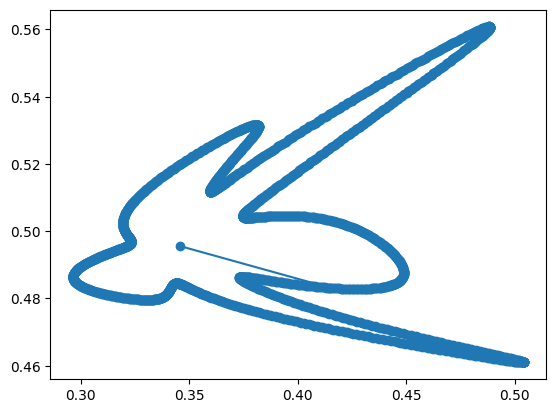

In [227]:
transformed = model(star)
transformed = transformed.detach().to('cpu')
transformed = np.array(transformed)

plt.plot(transformed[:,0], transformed[:,1], '-o')
#origin = model(torch.tensor([[0.,0.]]).to(device))
#compute_volume(torch.tensor(transformed), origin[0].to('cpu'))

In [2455]:
class TestNet(torch.nn.Module):
    def __init__(self, layer_size=2, split_size_x1=1, nn_size=(2, 2)):
        super(TestNet, self).__init__()
        device = torch.device("cpu")
        self.mask_triu = torch.triu(torch.ones(layer_size, layer_size)).bool()
        self.mask_tril = torch.tril(torch.ones(layer_size, layer_size)).bool().fill_diagonal_(False)
        
        self.activation = torch.nn.ReLU()
        self.upper = torch.nn.Linear(nn_size[1], nn_size[1], bias=False)
        
        upper = self.upper
        with torch.no_grad():
            mask = torch.diag(torch.ones(layer_size))
            upper.weight.copy_(torch.triu(upper.weight)) # set lower weights to zero
            upper.weight = torch.nn.Parameter(mask*torch.diag(torch.rand(layer_size)+0.1) + (1. - mask)*upper.weight)
        upper.weight.register_hook(get_zero_grad_hook(self.mask_triu, device)) # tell pytorch to not use lower weights in training

        self.lower = torch.nn.Linear(nn_size[1], nn_size[1], bias=False)
        lower = self.lower
        with torch.no_grad():
            lower.weight.copy_(torch.tril(lower.weight))
            lower.weight.copy_(lower.weight.fill_diagonal_(1))
        lower.weight.register_hook(get_zero_grad_hook(self.mask_tril, device))
    
    def forward(self, x, reverse=False):
        if reverse:
            #print(self.layer_1.weight, x.T)
            x = torch.linalg.solve_triangular(self.lower.weight, x.T, upper=False)
            x = torch.linalg.solve_triangular(self.upper.weight, x, upper=True)
            x = x.T
        else:
            #print(self.layer_1.weight)
            x = self.upper(x)
            x = self.lower(x)
        #print(x)
        return x


def get_zero_grad_hook(mask, device="cuda:0"):
    """zero out gradients"""

    def hook(grad):
        return grad * mask.to(device)

    return hook

In [3009]:
%%time
y = torch.tensor([[-0.1,-0.1], [1.,1.], [100,100.]])
activation = LeakySoftplus()
x = activation(y)
y_approx = activation(x)

step = torch.ones_like(y[:,0])

sign = torch.sign(torch.sum(y - y_approx, axis=1))
sign_changed = torch.zeros_like(y[:,0], dtype=torch.bool)
first_change = torch.zeros_like(y[:,0], dtype=torch.bool)

x += ((y - y_approx).T*step).T

while torch.any( torch.abs(torch.sum(y - y_approx, axis=1)) > 1e-6):  
    y_approx = activation(x)

    new_sign = torch.sign(torch.sum(y - y_approx, axis=1))
    sign_changed = torch.tensor(sign * new_sign < 0)
    sign = new_sign
    
    first_change = first_change | sign_changed | (sign == 0.)
    step[torch.logical_not(first_change)] *= 2
    step[sign_changed] /= 2
    
    x += ((y - y_approx).T*step).T
    
    #print(sign_changed, step, torch.abs(torch.sum(y - y_approx, axis=1)) > 1e-6)
    
    # x[torch.where(y_approx - y > 0)] = x[torch.where(y_approx - y > 0)]-step
    # x[torch.where(y_approx - y < 0)] = x[torch.where(y_approx - y < 0)]+step
    # y_approx = activation(x)
    # #print(y_approx, x)
    # step *= 0.99
activation(x), x

tensor([False, False, False]) tensor([2., 2., 1.]) tensor([ True,  True, False])
tensor([False,  True, False]) tensor([4., 1., 1.]) tensor([ True,  True, False])
tensor([False, False, False]) tensor([8., 1., 1.]) tensor([ True,  True, False])
tensor([ True, False, False]) tensor([4., 1., 1.]) tensor([ True,  True, False])
tensor([False, False, False]) tensor([4., 1., 1.]) tensor([ True,  True, False])
tensor([False, False, False]) tensor([4., 1., 1.]) tensor([ True,  True, False])
tensor([False, False, False]) tensor([4., 1., 1.]) tensor([ True,  True, False])
tensor([False, False, False]) tensor([4., 1., 1.]) tensor([ True,  True, False])
tensor([False, False, False]) tensor([4., 1., 1.]) tensor([ True,  True, False])
tensor([False, False, False]) tensor([4., 1., 1.]) tensor([False,  True, False])
tensor([False, False, False]) tensor([4., 1., 1.]) tensor([False,  True, False])
tensor([False, False, False]) tensor([4., 1., 1.]) tensor([False, False, False])
CPU times: total: 15.6 ms
Wa

<timed exec>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(tensor([[ -0.1000,  -0.1000],
         [  1.0000,   1.0000],
         [100.0000, 100.0000]]),
 tensor([[ -2.0698,  -2.0698],
         [  0.6092,   0.6092],
         [100.0000, 100.0000]]))

In [2999]:
x, y_approx, sign, sign_changed, ((y - y_approx).T*step).T,

(tensor([[  0.5700,   0.5700],
         [  1.2819,   1.2819],
         [100.0000, 100.0000]]),
 tensor([[  0.9734,   0.9734],
         [  1.5023,   1.5023],
         [100.0000, 100.0000]]),
 tensor([-1., -1.,  0.]),
 tensor([False, False, False]),
 tensor([[-1.0734, -1.0734],
         [-0.5023, -0.5023],
         [ 0.0000,  0.0000]]))

In [2954]:
torch.sign(y_approx - y)
torch.zeros_like(y[:,0], dtype=torch.bool)
sign, new_sign

(tensor([-1., -1.]), tensor([-1., -1.]))

In [2956]:
torch.tensor([-1.,1.], dtype = torch.bool)

tensor([True, True])

In [3003]:
y_approx = activation(x)

new_sign = torch.sign(torch.sum(y - y_approx, axis=1))
sign_changed = torch.tensor(sign * new_sign > 0)
sign = new_sign

first_change = first_change | sign_changed
step[torch.logical_not(first_change)] *= 2
step[sign_changed] /= 2

x += ((y - y_approx).T*step).T


C:\Users\Admin\AppData\Local\Temp\ipykernel_17272\3949298461.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sign_changed = torch.tensor(sign * new_sign > 0)


tensor([1., 1.])

In [3002]:
sign_changed, torch.logical_not(first_change), new_sign

(tensor([ True,  True, False]),
 tensor([False, False,  True]),
 tensor([-1., -1.,  0.]))

In [2925]:
%%time
x = torch.arange(-1000., 1000.001, 0.001)
activation = LeakySoftplus()
y_real = activation(x)
y_real
x[torch.searchsorted(y_real, y)]

CPU times: total: 141 ms
Wall time: 31 ms


tensor([[-2.0690, -2.0690],
        [ 0.6100,  0.6100]])

In [2920]:
torch.searchsorted(y_real, y), x

(tensor([[ 997931,  997931],
         [1000610, 1000610]]),
 tensor([-1000.0000,  -999.9990,  -999.9980,  ...,   999.9980,   999.9990,
          1000.0000]))

In [2922]:
x[torch.searchsorted(y_real, y)]

tensor([[-2.0690, -2.0690],
        [ 0.6100,  0.6100]])

In [2910]:
activation(torch.tensor([[-1000]]))

tensor([[-100.]])

In [2707]:
torch.sum((y_approx - y)**2, axis=1)

tensor([0.5047])

In [2785]:
InvertedLeakySoftplus2.apply(torch.tensor([[1,1]]))

tensor([[0.6087, 0.6087]])

In [2815]:
activation = LeakySoftplus()

x = torch.tensor([[1,1.]], requires_grad=True)
z = InvertedLeakySoftplus2.apply(x)
z2 = activation(z)
v = torch.sum(z2 - x)
v.backward()

In [2903]:
x = torch.arange(-1000., 1000.001, 0.001)
activation = LeakySoftplus()
y = activation(x)
tck = interpolate.splrep(y, x, s=0)

In [2904]:
tck

(array([-100., -100., -100., ..., 1000., 1000., 1000.]),
 array([-1000.        ,  -999.99933333,  -999.99833333, ...,
            0.        ,     0.        ,     0.        ]),
 3)

In [2807]:
z2, z

# alpha = 0.1
# der = alpha + (1-alpha)/(1+torch.exp(x)) * torch.exp(x)
# der, (1-alpha)/(1+torch.exp(x))* torch.exp(x)

(tensor([[0.9997, 0.9997]], grad_fn=<AddBackward0>),
 tensor([[0.6087, 0.6087]], grad_fn=<InvertedLeakySoftplus2Backward>))

In [2816]:
x.grad, v

(tensor([[0., 0.]]), tensor(-0.0006, grad_fn=<SumBackward0>))

In [ ]:
l = LeakySoftplus()
l(torch.tensor([[1.2819, 1.2819]]))

In [4193]:
import torch
import torch.nn as nn
from torch import Tensor
from scipy import interpolate

class LeakySoftplus(nn.Module):
    def __init__(self, alpha: float = 0.1) -> None:
        super(LeakySoftplus, self).__init__()
        self.alpha = alpha

    def forward(self, input: Tensor) -> Tensor:
        softplus = torch.log1p(torch.exp(-torch.abs(input))) + torch.maximum(input, torch.tensor(0))
        output = self.alpha * input + (1 - self.alpha) * softplus
        return output
        
class InvertedLeakySoftplus(nn.Module):
    def __init__(self, alpha: float = 0.1):
        super(InvertedLeakySoftplus, self).__init__()
        self.alpha = alpha

    def forward(self, input: Tensor):
        x = torch.arange(-1000., 1000.001, 0.001)
        activation = LeakySoftplus()
        y = activation(x)
        tck = interpolate.splrep(y, x, s=0)
        """data is first moved to cpu and then converted to numpy array"""
        yfit = interpolate.splev(input.cpu().detach().numpy(), tck, der=0)
        return torch.tensor(yfit).to(device)


class InvertedLeakySoftplus(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    
    @staticmethod
    def forward(ctx, y):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        # activation = LeakySoftplus()
        # x = activation(y)
        # y_approx = activation(x)
        # factor = 0.1
        # step = 0.1
        # while torch.any(torch.sum((y_approx - y)**2, axis=1) > 1e-6): 
        #     x[torch.where(y_approx - y > 0)] = x[torch.where(y_approx - y > 0)]-step
        #     x[torch.where(y_approx - y < 0)] = x[torch.where(y_approx - y < 0)]+step
        #     y_approx = activation(x)
        #     #print(y_approx, x)
        #     step *= 0.99
            
        # activation = LeakySoftplus()
        # x = torch.arange(-1000., 1000.001, 0.001).to(device)
        # y_real = activation(x)
        # x = x[torch.searchsorted(y_real, y)]


        activation = LeakySoftplus()
        x = activation(y)
        y_approx = activation(x)
        
        step = torch.ones_like(y[:,0])
        
        sign = torch.sign(torch.sum(y - y_approx, axis=1))
        sign_changed = torch.zeros_like(y[:,0], dtype=torch.bool)
        first_change = torch.zeros_like(y[:,0], dtype=torch.bool)
        
        x += ((y - y_approx).T*step).T
        
        while torch.any( torch.abs(torch.sum(y - y_approx, axis=1)) > 1e-6):  
            y_approx = activation(x)
        
            new_sign = torch.sign(torch.sum(y - y_approx, axis=1))
            sign_changed = torch.tensor(sign * new_sign < 0)
            sign = new_sign
            
            first_change = first_change | sign_changed | (sign == 0.)
            step[torch.logical_not(first_change)] *= 2
            step[sign_changed] /= 2
            
            x += ((y - y_approx).T*step).T
        
        ctx.save_for_backward(x)
        return x

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        x, = ctx.saved_tensors
        alpha = 0.1
        der = alpha + (1-alpha)/(1+torch.exp(x)) * torch.exp(x)
        return grad_output * 1/der

class TestNet(nn.Module):
    def __init__(self, num_lu_blocks=1, layer_size=2, device="cuda:0"):
        super(TestNet, self).__init__()
    
        """masks to zero out gradients"""
        self.mask_triu = torch.triu(torch.ones(layer_size, layer_size)).bool()
        self.mask_tril = torch.tril(torch.ones(layer_size, layer_size)).bool().fill_diagonal_(False)
        #print(self.mask_triu, self.mask_tril)
        self.nonlinearity = LeakySoftplus()
        self.inverted_nonlinearity = InvertedLeakySoftplus

        mask = torch.diag(torch.ones(layer_size))
        
        """create LU modules"""
        self.intermediate_lu_blocks = nn.ModuleList()
        """adding number of LU Blocks"""
        for i in range(num_lu_blocks):
            """init upper triangular weight matrix U without bias"""
            self.intermediate_lu_blocks.append(nn.Linear(layer_size, layer_size, bias=False))
            upper = self.intermediate_lu_blocks[-1]
            with torch.no_grad():
                upper.weight.copy_(torch.triu(upper.weight)) # set lower weights to zero
                upper.weight = torch.nn.Parameter(mask*torch.diag(torch.rand(layer_size)+0.1) + (1. - mask)*upper.weight)
            upper.weight.register_hook(get_zero_grad_hook(self.mask_triu, device)) # tell pytorch to not use lower weights in training
            """init lower triangular weight matrix L with bias"""
            self.intermediate_lu_blocks.append(nn.Linear(layer_size, layer_size))
            lower = self.intermediate_lu_blocks[-1]
            with torch.no_grad():
                lower.weight.copy_(torch.tril(lower.weight))
                lower.weight.copy_(lower.weight.fill_diagonal_(1))
            lower.weight.register_hook(get_zero_grad_hook(self.mask_tril, device))

        """Adding one final LU block = extra block"""
        self.final_lu_block = nn.ModuleList()
        """init upper triangular weight matrix U without bias"""
        self.final_lu_block.append(nn.Linear(layer_size, layer_size, bias=False))
        upper = self.final_lu_block[-1]
        with torch.no_grad():
            upper.weight.copy_(torch.triu(upper.weight))
            upper.weight = torch.nn.Parameter(mask*torch.diag(torch.rand(layer_size)+0.1) + (1. - mask)*upper.weight)
        upper.weight.register_hook(get_zero_grad_hook(self.mask_triu, device))
        """init lower triangular weight matrix L with bias"""
        self.final_lu_block.append(nn.Linear(layer_size, layer_size))
        lower = self.final_lu_block[-1]
        with torch.no_grad():
            lower.weight.copy_(torch.tril(lower.weight))
            lower.weight.copy_(lower.weight.fill_diagonal_(1))
        lower.weight.register_hook(get_zero_grad_hook(self.mask_tril, device))

    def forward(self, x, reverse=False):
        if not reverse:
            #x = torch.flatten(x, 1)
            for i, layer in enumerate(self.intermediate_lu_blocks):
                x = layer(x)
                if i % 2 == 1:  # after one L and U matrix
                    """apply non-linear activation"""
                    x = self.nonlinearity(x)

            """final LU block without activation"""
            for i, layer in enumerate(self.final_lu_block):
                x = layer(x)
            return x
        else:
            x = torch.flatten(x, 1)

            """final LU block without activation"""
            for i, layer in reversed(list(enumerate(self.final_lu_block))):
                if i % 2 == 1:
                    x = x - layer.bias
                    x = torch.linalg.solve(layer.weight, x.T)
                    
                if i % 2 == 0:  
                    x = torch.linalg.solve(layer.weight, x)
            
            l = []
            for i, layer in reversed(list(enumerate(self.intermediate_lu_blocks))):
                if i % 2 == 1:
                    if len(l) == 0:
                        #l.append(x)
                        l.append(self.inverted_nonlinearity.apply(x)) 
                    else:
                        #pass
                        l.append(self.inverted_nonlinearity.apply(l[-1]))
                    
                    l[-1] = l[-1] - layer.bias.reshape(2,1)
                    l[-1] = torch.linalg.solve(layer.weight, l[-1])
                    
                if i % 2 == 0:  
                    l[-1] = torch.linalg.solve(layer.weight, l[-1])
                    
                    
            return l[-1].T


def get_zero_grad_hook(mask, device="cuda:0"):
    """zero out gradients"""

    def hook(grad):
        return grad * mask.to(device)

    return hook

device = torch.device("cuda:0" if True else "cpu")
testNN = TestNet(num_lu_blocks=12, layer_size = 2).to(device)
#testNN(torch.tensor([[0,0.]]).to(device), reverse=False)
testNN(testNN(torch.tensor([[10,10.]]).to(device), reverse=False), reverse=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17272\2871826420.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sign_changed = torch.tensor(sign * new_sign < 0)


tensor([[-3286049.3098, -2477091.3091]], device='cuda:0',
       grad_fn=<PermuteBackward0>)

In [3018]:
testNN(torch.tensor([[0,0.]]).to(device), reverse=False)#, testNN(torch.tensor([[0.0584, 0.6467]]).to(device), reverse=True)

tensor([[-0.8482,  1.0018]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [2878]:
testNN(torch.tensor([[-0.0250, -0.3270]]).to(device), reverse=True)

1
Parameter containing:
tensor([[ 1.0000,  0.0000],
        [-0.6948,  1.0000]], device='cuda:0', requires_grad=True) Parameter containing:
tensor([-0.1267, -0.4379], device='cuda:0', requires_grad=True)
tensor([[0.1017, 0.1109]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[0.1017],
        [0.1816]], device='cuda:0', grad_fn=<LinalgSolveTriangularBackward0>)
0
tensor([[0.5429],
        [0.3019]], device='cuda:0', grad_fn=<LinalgSolveTriangularBackward0>)
1
tensor([[0.5429],
        [0.3019]], device='cuda:0', grad_fn=<LinalgSolveTriangularBackward0>)
tensor([[0.5429],
        [0.3019]], device='cuda:0', grad_fn=<LinalgSolveTriangularBackward0>)
0
tensor([[0.5429],
        [0.3019]], device='cuda:0', grad_fn=<LinalgSolveTriangularBackward0>)


tensor([[-0.0024, -0.0007]], device='cuda:0', grad_fn=<PermuteBackward0>)

In [3129]:
torch.set_default_dtype(torch.float64)
model = TestNet(num_lu_blocks=2, layer_size = 2).to(device)
model(model(torch.tensor([[1.,1.]]).to(device)), reverse=True), model(torch.tensor([[1.,1.]]).to(device), reverse=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17272\2426194416.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sign_changed = torch.tensor(sign * new_sign < 0)


(tensor([[1.0000, 1.0000]], device='cuda:0', grad_fn=<PermuteBackward0>),
 tensor([[ -1.0706, -62.8225]], device='cuda:0', grad_fn=<PermuteBackward0>))

In [2822]:
model

TestNet(
  (nonlinearity): LeakySoftplus()
  (intermediate_lu_blocks): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=False)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=2, bias=False)
    (3): Linear(in_features=2, out_features=2, bias=True)
  )
  (final_lu_block): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=False)
    (1): Linear(in_features=2, out_features=2, bias=True)
  )
)

In [2479]:
model.upper.weight, model.lower.weight

AttributeError: 'TestNet' object has no attribute 'upper'

In [2070]:
mask = torch.diag(torch.ones(2))
mask

tensor([[1., 0.],
        [0., 1.]])

In [1856]:
mask*torch.diag(torch.rand(2)+0.1) + (1. - mask)*model.lower.weight

tensor([[0.6898, 0.0000],
        [0.0900, 0.3669]], grad_fn=<AddBackward0>)

In [3130]:
def loss_fn(input, output):
    return torch.sum((input-output)**2)

In [3606]:
train_loader = generate_square(10000).to(device)
train_loader

tensor([[-0.1638,  0.1693],
        [-0.1148, -0.1316],
        [-0.0667,  0.0045],
        ...,
        [ 0.1489, -0.0017],
        [-0.0225,  0.1886],
        [-0.0804,  0.1502]], device='cuda:0')

In [4170]:
x_range=(-1., 1.)
y_range=(-1., 1.)
grid_width = 10

x = np.linspace(*x_range, grid_width)
y = np.linspace(*y_range, grid_width)

xv, yv = np.meshgrid(x, y, indexing='xy')
horizontal_lines = np.stack((xv, yv), axis=2)
all_grid_points = np.concatenate(horizontal_lines, axis=0)
train_loader = torch.tensor(all_grid_points).to(device)
train_loader

tensor([[-1.0000, -1.0000],
        [-0.7778, -1.0000],
        [-0.5556, -1.0000],
        [-0.3333, -1.0000],
        [-0.1111, -1.0000],
        [ 0.1111, -1.0000],
        [ 0.3333, -1.0000],
        [ 0.5556, -1.0000],
        [ 0.7778, -1.0000],
        [ 1.0000, -1.0000],
        [-1.0000, -0.7778],
        [-0.7778, -0.7778],
        [-0.5556, -0.7778],
        [-0.3333, -0.7778],
        [-0.1111, -0.7778],
        [ 0.1111, -0.7778],
        [ 0.3333, -0.7778],
        [ 0.5556, -0.7778],
        [ 0.7778, -0.7778],
        [ 1.0000, -0.7778],
        [-1.0000, -0.5556],
        [-0.7778, -0.5556],
        [-0.5556, -0.5556],
        [-0.3333, -0.5556],
        [-0.1111, -0.5556],
        [ 0.1111, -0.5556],
        [ 0.3333, -0.5556],
        [ 0.5556, -0.5556],
        [ 0.7778, -0.5556],
        [ 1.0000, -0.5556],
        [-1.0000, -0.3333],
        [-0.7778, -0.3333],
        [-0.5556, -0.3333],
        [-0.3333, -0.3333],
        [-0.1111, -0.3333],
        [ 0.1111, -0

In [4133]:
torch.set_default_dtype(torch.float64)
model = TestNet(num_lu_blocks=3, layer_size = 2).to(device)
model(torch.tensor([[1., 1.]]).to(device), reverse=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17272\3038577845.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sign_changed = torch.tensor(sign * new_sign < 0)


tensor([[ 82.3908, -10.5470]], device='cuda:0', grad_fn=<PermuteBackward0>)

In [4157]:
from tqdm import tqdm

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.)#, weight_decay=0.1
#optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=0.01)
#scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
num_epochs = 1
batch_size=10

In [4187]:
%%time

model.train()

for _ in range(num_epochs):
    print(_)
    train_loader = train_loader[torch.randperm(len(train_loader))]
    for k in tqdm(range(int(len(train_loader) / batch_size))):
        optimizer.zero_grad(set_to_none=True)
        input = train_loader[k * batch_size: k * batch_size + batch_size]
        #print(train_loader)
        output = model(input, reverse=True)
        loss = loss_fn(input, output)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, norm_type=1)
        optimizer.step()

print(model(torch.tensor([[1., 1.]]).to(device), reverse=True), loss)

0


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_17272\3038577845.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sign_changed = torch.tensor(sign * new_sign < 0)
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.46it/s]


tensor([[0.9119, 0.4658]], device='cuda:0', grad_fn=<PermuteBackward0>) tensor(0.6828, device='cuda:0', grad_fn=<SumBackward0>)
CPU times: total: 1 s
Wall time: 998 ms


In [3024]:
output
optimizer.zero_grad(set_to_none=True)
input = train_loader[5:6]
#print(train_loader)
output = model(input, reverse=True)
loss = loss_fn(input, output)
loss.backward()
optimizer.step()

C:\Users\Admin\AppData\Local\Temp\ipykernel_17272\2973413146.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sign_changed = torch.tensor(sign * new_sign < 0)


In [2837]:
model(input, reverse=True), output, model(output)

(tensor([[ -0.6036, -10.0209]], device='cuda:0', grad_fn=<PermuteBackward0>),
 tensor([[ -0.4080, -10.8593]], device='cuda:0', grad_fn=<PermuteBackward0>),
 tensor([[-0.0324, -0.0414]], device='cuda:0', grad_fn=<AddmmBackward0>))

In [4058]:
for b in model.intermediate_lu_blocks:
    print(b.weight, b.weight.grad)
model.final_lu_block[0].weight, model.final_lu_block[0].weight.grad, model.final_lu_block[1].weight, model.final_lu_block[1].weight.grad

Parameter containing:
tensor([[0.8817, 0.1694],
        [0.0000, 1.0591]], device='cuda:0', requires_grad=True) tensor([[-0.0292,  0.0030],
        [ 0.0000, -0.0013]], device='cuda:0')
Parameter containing:
tensor([[1.0000, 0.0000],
        [0.1290, 1.0000]], device='cuda:0', requires_grad=True) tensor([[-0.0000, 0.0000],
        [0.0064, -0.0000]], device='cuda:0')
Parameter containing:
tensor([[0.8833, 0.2590],
        [0.0000, 0.6892]], device='cuda:0', requires_grad=True) tensor([[-0.0293,  0.0054],
        [ 0.0000, -0.0030]], device='cuda:0')
Parameter containing:
tensor([[ 1.0000,  0.0000],
        [-0.0871,  1.0000]], device='cuda:0', requires_grad=True) tensor([[-0.0000, 0.0000],
        [0.0096, -0.0000]], device='cuda:0')
Parameter containing:
tensor([[ 0.8396, -0.7108],
        [ 0.0000,  0.7055]], device='cuda:0', requires_grad=True) tensor([[-0.0253,  0.0875],
        [-0.0000,  0.0819]], device='cuda:0')
Parameter containing:
tensor([[1.0000, 0.0000],
        [0.5386, 1

(Parameter containing:
 tensor([[ 1.0979, -0.3215],
         [ 0.0000,  0.4431]], device='cuda:0', requires_grad=True),
 tensor([[-0.0067,  0.0625],
         [-0.0000,  0.1463]], device='cuda:0'),
 Parameter containing:
 tensor([[ 1.0000,  0.0000],
         [-0.1117,  1.0000]], device='cuda:0', requires_grad=True),
 tensor([[-0.0000,  0.0000],
         [-0.0642,  0.0000]], device='cuda:0'))

In [2386]:
model.upper.weight.grad

tensor([[-0.2127, -0.1871],
        [ 0.0000,  0.0562]])

In [4189]:
x_range=(-1., 1.)
y_range=(-1., 1.)
grid_width = 3

x = np.linspace(*x_range, grid_width)
y = np.linspace(*y_range, grid_width)

xv, yv = np.meshgrid(x, y, indexing='xy')
horizontal_lines = np.stack((xv, yv), axis=2)
all_grid_points = np.concatenate(horizontal_lines, axis=0)
train_loader = torch.tensor(all_grid_points, device=device)
train_loader

tensor([[-1., -1.],
        [ 0., -1.],
        [ 1., -1.],
        [-1.,  0.],
        [ 0.,  0.],
        [ 1.,  0.],
        [-1.,  1.],
        [ 0.,  1.],
        [ 1.,  1.]], device='cuda:0')

In [2086]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm

C:\Users\Admin\AppData\Local\Temp\ipykernel_17272\3038577845.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sign_changed = torch.tensor(sign * new_sign < 0)


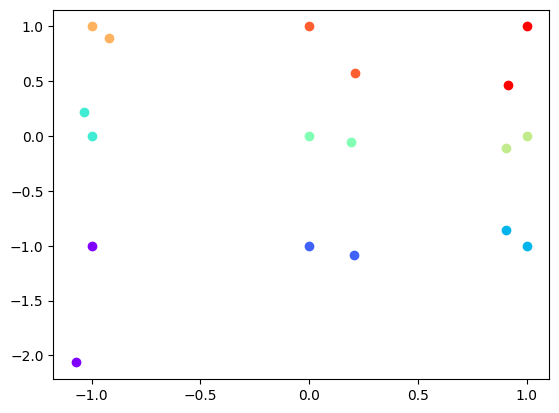

In [4190]:
colors = cm.rainbow(np.linspace(0, 1, 9))
transformed = model(train_loader, reverse=True)
transformed=transformed.detach().to('cpu')

train_loader = train_loader.to('cpu')

for i, c in enumerate(colors):
    plt.scatter(train_loader[i,0], train_loader[i,1], color=c)
    plt.scatter(transformed[i,0], transformed[i,1], color=c)

In [852]:
from torch.optim.lr_scheduler import StepLR

In [1899]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.)
scheduler = StepLR(optimizer, step_size=100, gamma=0.99)
num_epochs = 10
batch_size= 32

In [1884]:
model = TestNet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.)
print(model(torch.tensor([[1.]]), reverse=True))
model.upper.weight#, model.lower.weight

RuntimeError: linalg.solve_triangular: Incompatible shapes of A and B for the equation AX = B (2x2 and 1x1)

In [1785]:
def loss_fn(input, output, quadrants=torch.tensor([[-1]])):
    return torch.sum((input-quadrants*output)**2)

In [1735]:
train_loader = torch.tensor([[1.]])

In [1919]:
model.train()


for k in range(int(len(train_loader) / batch_size)):
    optimizer.zero_grad(set_to_none=True)
    input = train_loader[k * batch_size: k * batch_size + batch_size]
    print(train_loader)
    output = model(input, reverse=True)
    loss = loss_fn(input, output)
    loss.backward()
    optimizer.step()

print(model(torch.tensor([[1., 1.]]), reverse=True), loss)

tensor([[-0.0438],
        [-0.0580],
        [-0.0562],
        ...,
        [-0.1290],
        [-0.1353],
        [-0.0771]])


RuntimeError: linalg.solve_triangular: Incompatible shapes of A and B for the equation AX = B (2x2 and 1x32)

In [1912]:
train_loader, output, input

(tensor([[-1.5000, -1.5000],
         [ 0.0000, -1.5000],
         [ 1.5000, -1.5000],
         [-1.5000,  0.0000],
         [ 0.0000,  0.0000],
         [ 1.5000,  0.0000],
         [-1.5000,  1.5000],
         [ 0.0000,  1.5000],
         [ 1.5000,  1.5000]]),
 tensor([[-1.0043]], grad_fn=<PermuteBackward0>),
 tensor([[1.]]))

In [1818]:
optimizer.zero_grad(set_to_none=True)
input = train_loader
print(train_loader)
output = model(input, reverse=True)
loss = loss_fn(input, output)
loss.backward()
optimizer.step()
with torch.no_grad():
    print(model(torch.tensor([[1.]]), reverse=True), loss)

tensor([[1.]])
tensor([[-1.0034]]) tensor(1.8114e-05, grad_fn=<SumBackward0>)


In [1558]:
model(torch.tensor([[1.,1.]]))

tensor([[ 15457.0286, 149289.0289]], grad_fn=<MmBackward0>)

In [1733]:
A = model.upper.weight

In [1804]:
model.upper.weight#, model.lower.weight

D:\master-thesis\venv\Lib\site-packages\IPython\core\displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


Parameter containing:
tensor([[-369.5529]], requires_grad=True)

In [1803]:
model.upper.weight.grad

tensor([[-1.4605e-05]])

In [1576]:
optimizer.zero_grad(set_to_none=True)
input = train_loader[:1]
output = model(input, reverse=False)
loss = loss_fn(input, output)
loss.backward()
loss

tensor(2.5985e+08, grad_fn=<SumBackward0>)

In [1577]:
input - output, output

(tensor([[  565.2504, 16109.9446]], grad_fn=<SubBackward0>),
 tensor([[  -565.1545, -16110.0525]], grad_fn=<MmBackward0>))

In [1578]:
model.upper.weight.grad#, model.lower.weight.grad

tensor([[-108.3945,  121.9944],
        [  -0.0000, 3476.9073]])

In [1579]:
optimizer.step()

In [1580]:
model.upper.weight#, model.lower.weight

Parameter containing:
tensor([[  5422.4003,  10033.2682],
        [     0.0000, 148941.3381]], requires_grad=True)

In [889]:
1.5*1.36, 1.5*2.92

(2.04, 4.38)